In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import RFE

In [2]:
train = pd.read_csv("/Users/priyankam/Documents/GitHub/Data_Science/Classification/train.csv")
test = pd.read_csv("/Users/priyankam/Documents/GitHub/Data_Science/Classification/test.csv")


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
train.drop(columns=['Cabin', 'Ticket', 'Name'], inplace=True)

/var/folders/5v/1f87_8ss0z3_1vz8yv1kv37w0000gn/T/ipykernel_72419/3176873566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/var/folders/5v/1f87_8ss0z3_1vz8yv1kv37w0000gn/T/ipykernel_72419/3176873566.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [5]:
train['TravelAlone'] = np.where((train['SibSp'] + train['Parch']) == 0, 1, 0)
train['IsMinor'] = np.where(train['Age'] <= 16, 1, 0)

In [6]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

In [7]:
X = train.drop(['Survived', 'PassengerId'], axis=1)
y = train['Survived']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
lm = LogisticRegression(max_iter=1000)
lm.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
coeff_df = pd.DataFrame(lm.coef_[0], X.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)


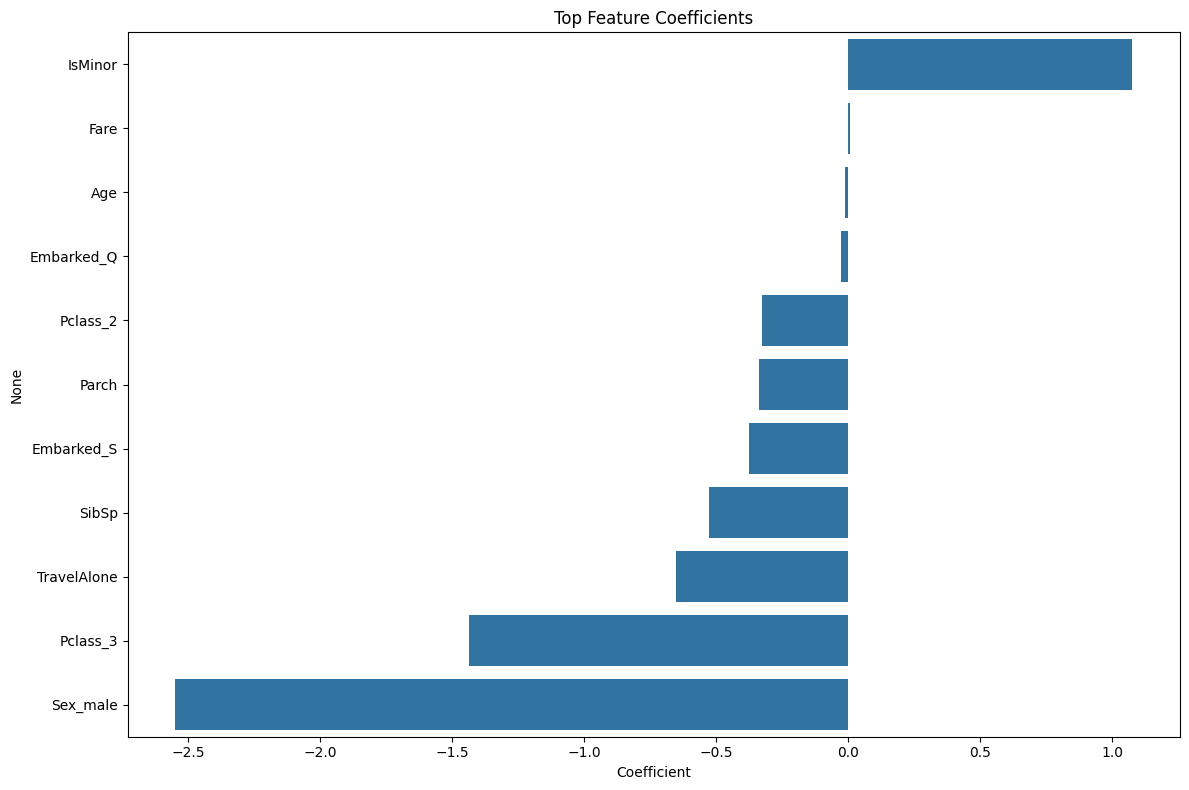

In [11]:
plt.figure(figsize=(12, 8))
top_features = pd.concat([coeff_df.head(10), coeff_df.tail(10)])
sns.barplot(x=top_features['Coefficient'], y=top_features.index)
plt.title('Top Feature Coefficients')
plt.tight_layout()
plt.show()


In [12]:
y_pred = lm.predict(X_test)
y_pred_prob = lm.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_prob), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.81
ROC AUC: 0.881

Confusion Matrix:
 [[91 14]
 [20 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [13]:
cv_score = cross_val_score(lm, X, y, cv=10, scoring='roc_auc')
print("\n10-Fold CV AUC Mean:", round(cv_score.mean(), 3))


10-Fold CV AUC Mean: 0.86


In [14]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print("\nBest C Parameter:", grid.best_params_)
print("Best CV AUC:", round(grid.best_score_, 3))


Best C Parameter: {'C': 1}
Best CV AUC: 0.845


In [15]:
best_model = grid.best_estimator_
y_pred_final = best_model.predict(X_test)
print("\nFinal Accuracy:", round(accuracy_score(y_test, y_pred_final), 3))
print("Final ROC AUC:", round(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]), 3))


Final Accuracy: 0.81
Final ROC AUC: 0.881
